In [1]:
%%capture
!pip install networkx numpy pandas statsmodels

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import statsmodels.api as sm
from typing import Set

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Structural Causal Models

By Alessio Zanga and Fabio Stella

## Abstract

This notebook illustrates a step-by-step example on estimating the average causal effect (ACE) given the appropriate backdoor adjustment set.

## Introduction

Continuing from [the previous example](https://colab.research.google.com/github/AlessioZanga/CaMo/blob/develop/examples/potential_outcomes.ipynb), the complete **systolic blood pressure** vs **sodium intake** causal graph is represented below.

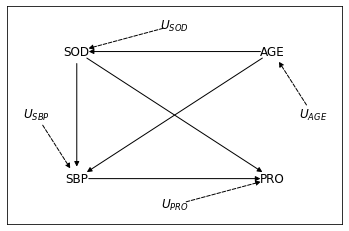

In [3]:
G = nx.DiGraph()
E_U = [("$U_{AGE}$", "AGE"), ("$U_{SOD}$", "SOD"), ("$U_{SBP}$", "SBP"), ("$U_{PRO}$", "PRO")]
E_V = [("SOD", "SBP"), ("AGE", "SOD"), ("AGE", "SBP"), ("SOD", "PRO"), ("SBP", "PRO")]
G.add_edges_from(E_U + E_V)   # Add exogenous and endogenous edges to graph
pos = nx.circular_layout(G)   # Predefine graph layout
_ = nx.draw_networkx_labels(G, pos)   # Plot node labels
sty = {"min_source_margin": 12, "min_target_margin": 12}         # Set min distance from labels
_ = nx.draw_networkx_edges(G, pos, E_U, style="dashed", **sty)   # Plot dashed exogenous edges
_ = nx.draw_networkx_edges(G, pos, E_V, style="solid", **sty)    # Plot solid endogenous edges

You are now able to match the previous **causal graph** to the sampling function, defining the associated **structural causal model (SCM)**.

The complete specification of the casual model $M$ is given by $M = <U, V, F>$, where: 

- $U = \{ U_{AGE}, \, U_{SOD}, \, U_{SBP}, \, U_{PRO} \}$,
- $V = \{ AGE, \, SOD, \, SBP, \, PRO \}$,
- $F = \{ f_{AGE}, f_{SOD}, f_{SBP}, f_{PRO} \}$.

In [4]:
def sample_data(size: int = int(1e6), seed: int = 31):
    # Set random generator seed for results reproducibility
    np.random.seed(seed)
    # Sample age with mean 65 and std 5
    age = np.random.normal(65, 5, size)
    # Sample sodium with additive noise
    sod = 0.056 * age + np.random.normal(0, 1, size)
    # Binarize sodium following cutoff
    sod = (sod > 3.5).astype(int)
    # Sample systolic blood pressure
    sbp = 1.05 * sod + 2 * age + np.random.normal(0, 1, size)
    # Sample urinary protein
    pro = 0.4 * sod + 0.3 * sbp + np.random.normal(0, 1, size)
    # Create a dataframe from sampled variables
    return pd.DataFrame({"AGE": age, "SOD": sod, "SBP": sbp, "PRO": pro})

Indeed, each line in this sampling function is a **structural equation** related to the **causal graph**:

- $AGE := f_{AGE}(U_{AGE}) := N(65, 5)$,
- $SOD := f_{SOD}(AGE, U_{SOD}) := I[(0.056 \cdot AGE + N(0, 1)) > 3.50]$,
- $SBP := f_{SBP}(AGE, SOD, U_{SBP}) := 1.05 \cdot SOD + 2.00 \cdot AGE + N(0, 1)$,
- $PRO := f_{PRO}(SOD, SBP, U_{PRO}) := 0.40 \cdot SOD + 0.30 \cdot SBP + N(0, 1)$,

where $N(\mu, \sigma)$ is a Gaussian noise with $\mu$ mean and $\sigma$ standard deviation and $I[X > x]$ is the indicator function.

Recall that the true ACE is given by the coefficient 1.05 that assign SBP a value given SOD.

In [5]:
data = sample_data()
data.describe()

,AGE,SOD,SBP,PRO
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,65.001134,0.552995,130.583161,39.396720
std,4.993518,0.497184,10.161539,3.263477
min,40.964418,0.000000,82.816817,24.421988
25%,61.627703,0.000000,123.720103,37.190745
50%,65.009236,1.000000,130.597297,39.402344
75%,68.372794,1.000000,137.445514,41.602773
max,87.717317,1.000000,176.708462,54.573313


## Methods

Assuming consistency, positivity, and unconfoundedness, the average causal effect (ACE) is defined:

In [6]:
def ACE(data: pd.DataFrame, X: str, Y: str, Z: Set[str]):
    # Define the regresion model formula
    formula = f"{Y} ~ {X}"
    if len(Z) != 0: formula += "+" + "+".join(Z)
    # Fit Ordinary Least Square regression model
    estimator = sm.OLS.from_formula(formula, data).fit()
    # Compute potential outcomes by fixing X
    Y1 = estimator.predict(data.assign(**{X: 1}))
    Y0 = estimator.predict(data.assign(**{X: 0}))
    # Compute average causal effect
    return np.mean(Y1 - Y0)

A set of variables **Z** satisfies the backdoor criterion relative to an ordered pair of variables (X, Y) if:

- No node in **Z** is a descendant of X; and
- **Z** blocks every path between X and Y that contains an arrow into X.

While the former condition is clearly stated, the latter could be obscure and should be investigated further. Stating that **"Z blocks every path (...)"** might be misleading. In this context, **blocking** is intended as **d-separing**, which maps the first part to **"Z d-separes every path (...)"**. Moreover, **"(...) that contains an arrow into X"** is a convoluted expression which refers to the **parents of X**.

In [7]:
def is_d_separated(G: nx.DiGraph, X: Set[str], Y: Set[str], Z: Set[str]) -> bool:
    # If X, Y, Z are not disjoint, then X and Y are d-separated by default
    if X & Z or Y & Z:
        return True
    return nx.d_separated(G, X, Y, Z)

One might be tempted to translate this condition as $Pa(X), Y \perp \!\!\! \perp_G \textbf{Z}$, but it would be incomplete: following the definition of d-separation, X, Y and **Z** are required to be disjoint. Therefore,  **Z** alone would not be sufficient to block *every path between X and Y*, indeed the *direct* path between X and Y is still open. The correct translation is $Pa(X), Y \perp \!\!\! \perp_G \textbf{Z} \cup \{ X \}$, where X itself blocks the direct path from X to Y, while **Z** blocks any *indirect* path from Pa(X) to Y.

In [8]:
def is_backdoor_adjustement_set(G: nx.DiGraph, X: str, Y: str, Z: Set[str]) -> bool:
    # (i) no node in Z is a descendant of X; and
    if Z & nx.descendants(G, X):
        return False
    # (ii) Z blocks every path between X and Y that contains an arrow into X.
    return all(is_d_separated(G, {W}, {Y}, Z | {X}) for W in G.predecessors(X))

## Results

The true ACE is:

In [9]:
ace = 1.05

The naive estimated ACE without adjustment is:

In [10]:
t = ACE(data, X = "SOD", Y = "SBP", Z = set())
f"Estimated ACE: {t:.3}, Relative Error: {(np.abs((t-ace)/ace*100)):.4}%"

'Estimated ACE: 5.37, Relative Error: 411.5%'

The estimated ACE adjusting for AGE and PRO is:

In [11]:
t = ACE(data, X = "SOD", Y = "SBP", Z = {"AGE", "PRO"})
f"Estimated ACE: {t:.3}, Relative Error: {(np.abs((t-ace)/ace*100)):.4}%"

'Estimated ACE: 0.856, Relative Error: 18.46%'

Let's check if the empty set $Z=\{\}$  is a backdoor adjustment set:

In [12]:
is_backdoor_adjustement_set(G, X = "SOD", Y = "SBP", Z = set())

False

Let's check if $Z = \{ AGE, PRO \}$ is a backdoor adjustment set:

In [13]:
is_backdoor_adjustement_set(G, X = "SOD", Y = "SBP", Z = {"AGE", "PRO"})

False

Indeed, we add bias by conditioning on $PRO$ since it is a collider. Let's check if $Z$ **without** $PRO$ is a backdoor adjustment set:

In [14]:
is_backdoor_adjustement_set(G, X = "SOD", Y = "SBP", Z = {"AGE"})

True

The estimated ACE adjusting for AGE alone is:

In [15]:
t = ACE(data, X = "SOD", Y = "SBP", Z = {"AGE"})
f"Estimated ACE: {t:.4}, Relative Error: {(np.abs((t-ace)/ace*100)):.4}%"

'Estimated ACE: 1.052, Relative Error: 0.2269%'

## Conclusions

Applying a naive regression model without adjustment leads to an estimated ACE which is four times off. A regression model with an adjustment set reduce the relative error to 18%. Instead, using a **backdoor** adjustment set lowered it to 0.2%.